ChaoTang

# Practical 7 - Part 2B
The goal of this part of the practical is to take a real image containing
a planar black square and figure out the transformation between the square
and the camera.  We will then draw a wire-frame cube with it's base
corners at the corner of the square.  You should use this
template for your code and fill in the missing sections marked "TO DO"

# Import libraries 

In [22]:
%matplotlib inline
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

# Load and display the image

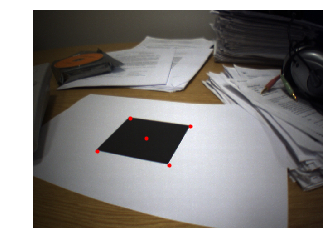

In [23]:
# Load image:
im = plt.imread('test104.jpg')

# Define points on image
XImCart = np.array([[140.3464,  212.1129,  346.3065,  298.1344,   247.9962],
             [308.9825,  236.7646,  255.4416,  340.7335,   281.5895]])

# Define 3D points of plane
XCart = np.array([[-50, -50,  50,  50, 0],
          [50, -50, -50,  50, 0],
          [0,   0,   0,   0, 0]])

# We assume that the intrinsic camera matrix K is known and has values:
K = np.array([[640,  0,  320],
             [0, 640, 240],
             [0,  0,  1]])

# Draw image and 2d points
plt.imshow(im)
plt.plot(XImCart[0,],XImCart[1,],'r.')
plt.axis('off')
plt.show()

## Comment:
The above figure displays the raw image of the base as well as the reference points on it. These reference points construct a bottom surface of the cube in the next section.

# **** TO DO **** apply the functions from part 2A  (estimatePlanePose, projectiveCamera) to take the image and figure out the transformation between the square and the camera. 

In [24]:
def solveAXEqualsZero(A):
    # TO DO: Write this routine - it should solve Ah = 0   
    U,L,VT = np.linalg.svd(A)
    VRow,Vcol = VT.shape
    h = VT[VRow -1,:]
    return h

In [25]:
# This function should apply the direct linear transform (DLT) algorithm to calculate the best 
# homography that maps the points in pts1Cart to their corresonding matching in pts2Cart
def calcBestHomography(pts1Cart, pts2Cart):    
    # TO DO: 
    # First convert points into homogeneous representation
    pts1Hom = np.concatenate((pts1Cart, np.ones((1,pts1Cart.shape[1]))), axis=0)
    pts2Hom = np.concatenate((pts2Cart, np.ones((1,pts1Cart.shape[1]))), axis=0)
    
    # Then construct the matrix A, size (2 * n_points,9)
    n_point, = pts1Cart[0,:].shape
    A = np.zeros((2 * n_point,9))
    
    for cpoint in range(n_point):
        currentVec1 = pts1Hom[:,cpoint]
        currentVec2 = pts2Hom[:,cpoint]
        
        A[2 * cpoint,:] = [0,0,0,-currentVec1[0],-currentVec1[1],-1,currentVec1[0]*currentVec2[1],currentVec1[1]*currentVec2[1],currentVec2[1]]
        A[2 * cpoint+1,:] = [currentVec1[0],currentVec1[1],1,0,0,0,-currentVec2[0]*currentVec1[0],-currentVec2[0]*currentVec1[1],-currentVec2[0]]
    
    # Solve Ah = 0
    h = solveAXEqualsZero(A)
    # Reshape h into the matrix H, values of h go first into rows of H
    H = np.reshape(h,(3,3))
    return H

In [26]:
#The goal of this function is to project points in XCart through projective camera
#defined by intrinsic matrix K and extrinsic matrix T.
def projectiveCamera(K,T,XCart):
    
    # TO DO: Replace this
    # XImCart =
    # TO DO: Convert Cartesian 3d points XCart to homogeneous coordinates XHom 
    ndim,ndata = XCart.shape
    hzero = np.ones(ndata)
    XHom = np.vstack((XCart,hzero))
    # TO DO: Apply extrinsic matrix to XHom, to move to frame of reference of camera
    FCamera = T @ XHom
    # TO DO: Project points into normalized camera coordinates xCamHom (remove 4th row)
    xCamHom = FCamera[0:3,:]
    # TO DO: Move points to image coordinates xImHom by applying intrinsic matrix
    xImHom = K @ xCamHom
    # TO DO: Convert points back to Cartesian coordinates xImCart
    XImCart_old = xImHom / xImHom[2,:]
    XImCart = XImCart_old[0:2,:]
    
    return XImCart

In [27]:
# Goal of function is to estimate pose of plane relative to camera (extrinsic matrix)
# given points in image xImCart, points in world XCart and intrinsic matrix K

def estimatePlanePose(XImCart,XCart,K):

    # TO DO: replace this
    # T = 

    # TO DO: Convert Cartesian image points XImCart to homogeneous representation XImHom
    ndim,ndata = XImCart.shape
    hzero = np.ones(ndata)
    XImHom = np.vstack((XImCart,hzero))
    
    # TO DO: Convert image co-ordinates XImHom to normalized camera coordinates XCamHom    
    XCamHom = np.linalg.inv(K) @ XImHom
    
    # TO DO: Estimate homography H mapping homogeneous (x,y) coordinates of positions
    # in real world to XCamHom (convert XCamHom to Cartesian, calculate the homography) -
    # use the routine you wrote for Practical 1B
    H = calcBestHomography(XCart[0:2,:],XCamHom)
          
    # TO DO: Estimate first two columns of rotation matrix R from the first two
    # columns of H using the SVD       
    A = H[:,0:2]
    U,L,VT = np.linalg.svd(A)
    R = np.zeros((3,3))
    Temp = np.array([[1,0],[0,1],[0,0]])
    R[:,0:2] = U @ Temp @ VT
    # TO DO: Estimate the third column of the rotation matrix by taking the cross
    # product of the first two columns
    R[:,2] = np.cross(R[:,0],R[:,1])
        
    # TO DO: Check that the determinant of the rotation matrix is positive - if
    # not then multiply last column by -1.
    Condition = np.linalg.det(R)
    if Condition < 0:
        R[:,2] = -R[:,2]
    
    # TO DO: Estimate the translation t by finding the appropriate scaling factor k
    # and applying it to the third colulmn of H
    k = 0
    for m in range(3):
        for n in range(2):
            k = k + H[m,n]/R[m,n]
    k = k/6
    print('k = ',k)
    Tao = np.zeros((3,1))
    Tao[:,0] = H[:,2]/k
    
    # TO DO: Check whether t_z is negative - if it is then multiply t by -1 and
    # the first two columns of R by -1.
    if Tao[2,:] <0:
        Tao = -Tao
        R[:,0:2] = -R[:,0:2]
    # TO DO: Assemble transformation into matrix form
    T = np.hstack((R,Tao))
    
    return T 

k =  0.00258458885427
(2, 8)


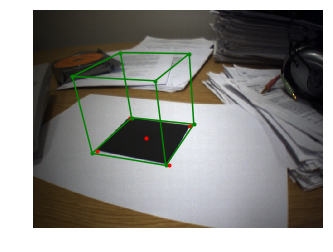

In [28]:
# TO DO: Use your routine to calculate TEst, the extrinsic matrix relating the
# plane position to the camera position.
TEst = estimatePlanePose(XImCart,XCart,K)

# Define 3D points of plane
XWireFrameCart = np.array([[-50, -50,  50,  50, -50, -50,  50,  50],
                   [50, -50, -50,  50,  50, -50, -50,  50],
                    [0,   0,   0,   0, -100, -100, -100, -100]]);

def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],'g-')
    
# TO DO: Draw a wire frame cube, by projecting the vertices of a 3D cube through
# the projective camera and drawing lines betweeen the resulting 2d image points
XWireFrameCartProjected = projectiveCamera(K,TEst,XWireFrameCart)
print(XWireFrameCartProjected.shape)
# Draw image, 2d points and projected 3D cube points
plt.imshow(im)
plt.plot(XImCart[0,],XImCart[1,],'r.')
plt.plot(XWireFrameCartProjected[0,],XWireFrameCartProjected[1,],'g.')

for i in range(3):
    connectpoints(XWireFrameCartProjected[0,:],XWireFrameCartProjected[1,:],i,i+1)
connectpoints(XWireFrameCartProjected[0,:],XWireFrameCartProjected[1,:],0,3)
for i in range(3):
    connectpoints(XWireFrameCartProjected[0,:],XWireFrameCartProjected[1,:],i+4,i+5)
connectpoints(XWireFrameCartProjected[0,:],XWireFrameCartProjected[1,:],4,7)
for i in range(4):
    connectpoints(XWireFrameCartProjected[0,:],XWireFrameCartProjected[1,:],i,i+4)

plt.axis('off')
plt.show()

## Comment: 
After doing the homography, we transform the local coordinates of a cube into the image coordinate and then display it in this figure.The structure of the cube looks realistic with slight deformation.However, we can see that the estimate green  points actually do not perfectly land on the red points.

# QUESTIONS TO THINK ABOUT...

Do the results look realistic?
If not, then what factors do you think might be causing this?

## Answer:
The result looks realistic for this case. However, there are also some potential factors that may lead to inrealistic homography.The first reason is the inaccurate estimation of the  H  matrix(homography matrix).This may cause the inaccurate position of the cube in the image.The second reason maybe the inaccurate intrinsic matrix.Because the K is manually set, it might be different for differnt camera,so the 'projectiveCamera' result may be inaccurate.